# LeafSim

## An Example-Based XAI for Decision Tree Based Ensemble Methods

# Summary

This blog presents `LeafSim`, an example-based **explainable AI** (**XAI**) technique for decision tree based ensemble methods.
The technique applies the Hamming distance on leaf indices to measure similarity between instances in the test and training set. It therefore explains model predictions by identifying training data points that most influenced a given prediction.

The proposed technique is:
- easy to interpret by non-technical people
- complementing existing XAI techniques
- straightforward to implement & maintain in production
- computationally lightweight

# Introduction

In this blog post, the focus will be on the topic of example-based XAI technique. As such, the article will introduce an approach that aims at complementing well established techniques, such as [SHAP](https://github.com/slundberg/shap) and [Lime](https://github.com/marcotcr/lime).<br/>
Specifically, the approach detailed aims at explaining individual predictions of decision tree based ensemble methods, such as [Catboost](https://github.com/catboost/catboost).

Existing XAI approaches, such as SHAP, provide insights into which features are most relevant, both globally and locally.
They can put predictions of individual datapoints into perspective, such as measuring how model predictions differ with varying feature values.

However, for people with limited knowledge in Machine Learning, it can be less intuitive to parse such information and to build an understanding of what underpins model predictions.

In such cases, providing example based explanations can be very helpful as will become evident in this blog post.

----
# Coding Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import required libraries
import glob

import matplotlib.pylab as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from IPython.display import Image

import seaborn as sns
from sklearn.metrics import DistanceMetric
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import shap
from catboost import CatBoostRegressor

# Helper functions
import sys
sys.path.append("../")
from src.utils import get_stylised_similar_cars_table, get_similarity_plots

In [3]:
# Define settings
plt.rcParams["figure.dpi"] = 200
font = {
    "family": "serif",
    "weight": "normal"
}
plt.rc("font", **font)
plt.rc("xtick", labelsize=8)
plt.rc("ytick", labelsize=8)
plt.rc("axes", labelsize=10)
plt.rc("figure", titlesize=12)
plt.rc("legend", fontsize=6)
np.random.seed(46)
shap.initjs()

-------
# Data

For the purpose of the analysis of the approach proposed and the examples given, a dataset on used cars is chosen.

It contains information - such as mileage and selling price - on roughly 100,000 used cars from various popular brands and is available on [Kaggle](https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes?select=merc.csv) (as of July 2022).

In [4]:
def load_df(filepath):
    df = pd.read_csv(filepath)
    # Clean column names
    df.columns = list(map(lambda x: x.strip().lower().replace(" ", "").replace("(£)", ""), df.columns))
    # Add brand (taken from filename)
    df["brand"] = filepath.split("/")[-1].replace(".csv", "")
    return df

In [5]:
df = pd.concat([
    # Disregard files whose name starts with "unclean"
    load_df(i) for i in glob.glob("../data/[!unclean]*.csv") 
])
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93973 entries, 0 to 93972
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         93973 non-null  object 
 1   year          93973 non-null  int64  
 2   price         93973 non-null  int64  
 3   transmission  93973 non-null  object 
 4   mileage       93973 non-null  int64  
 5   fueltype      93973 non-null  object 
 6   tax           88519 non-null  float64
 7   mpg           88519 non-null  float64
 8   enginesize    93973 non-null  float64
 9   brand         93973 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 7.2+ MB


For the purpose of this analysis, information regarding tax and miles per gallon is disregarded as those attributes are sometimes missing.

In [6]:
# Define features
feature_cols = [
    "brand",
    "model",
    "year",
    "mileage",
    "transmission",
    "fueltype",
    "enginesize"
]
# of which the following ones are of categorical type:
categorical_feature_cols = [
    "brand",
    "model",
    "fueltype",
    "transmission"
]

numeric_cols = [i for i in feature_cols if i not in categorical_feature_cols]

# Define the target of the model, i.e. what we want to predict
target_col = "price"

## Clean data

The first and only cleaning step involves removing entries with unrealistic attributes (cars built in the future and those with an engine capacity of zero litres). 

In [7]:
df = (
    df
    .loc[
        lambda x: 
        (x.enginesize > 0) & 
        (x.year <= 2022)
    ]
    .copy()
    .reset_index(drop=True)
)
# Add an ID to allow referencing instances between df_train / df_test and df
df["ID"] = df.index

With this, let's obtain high level summaries of the considered attributes.

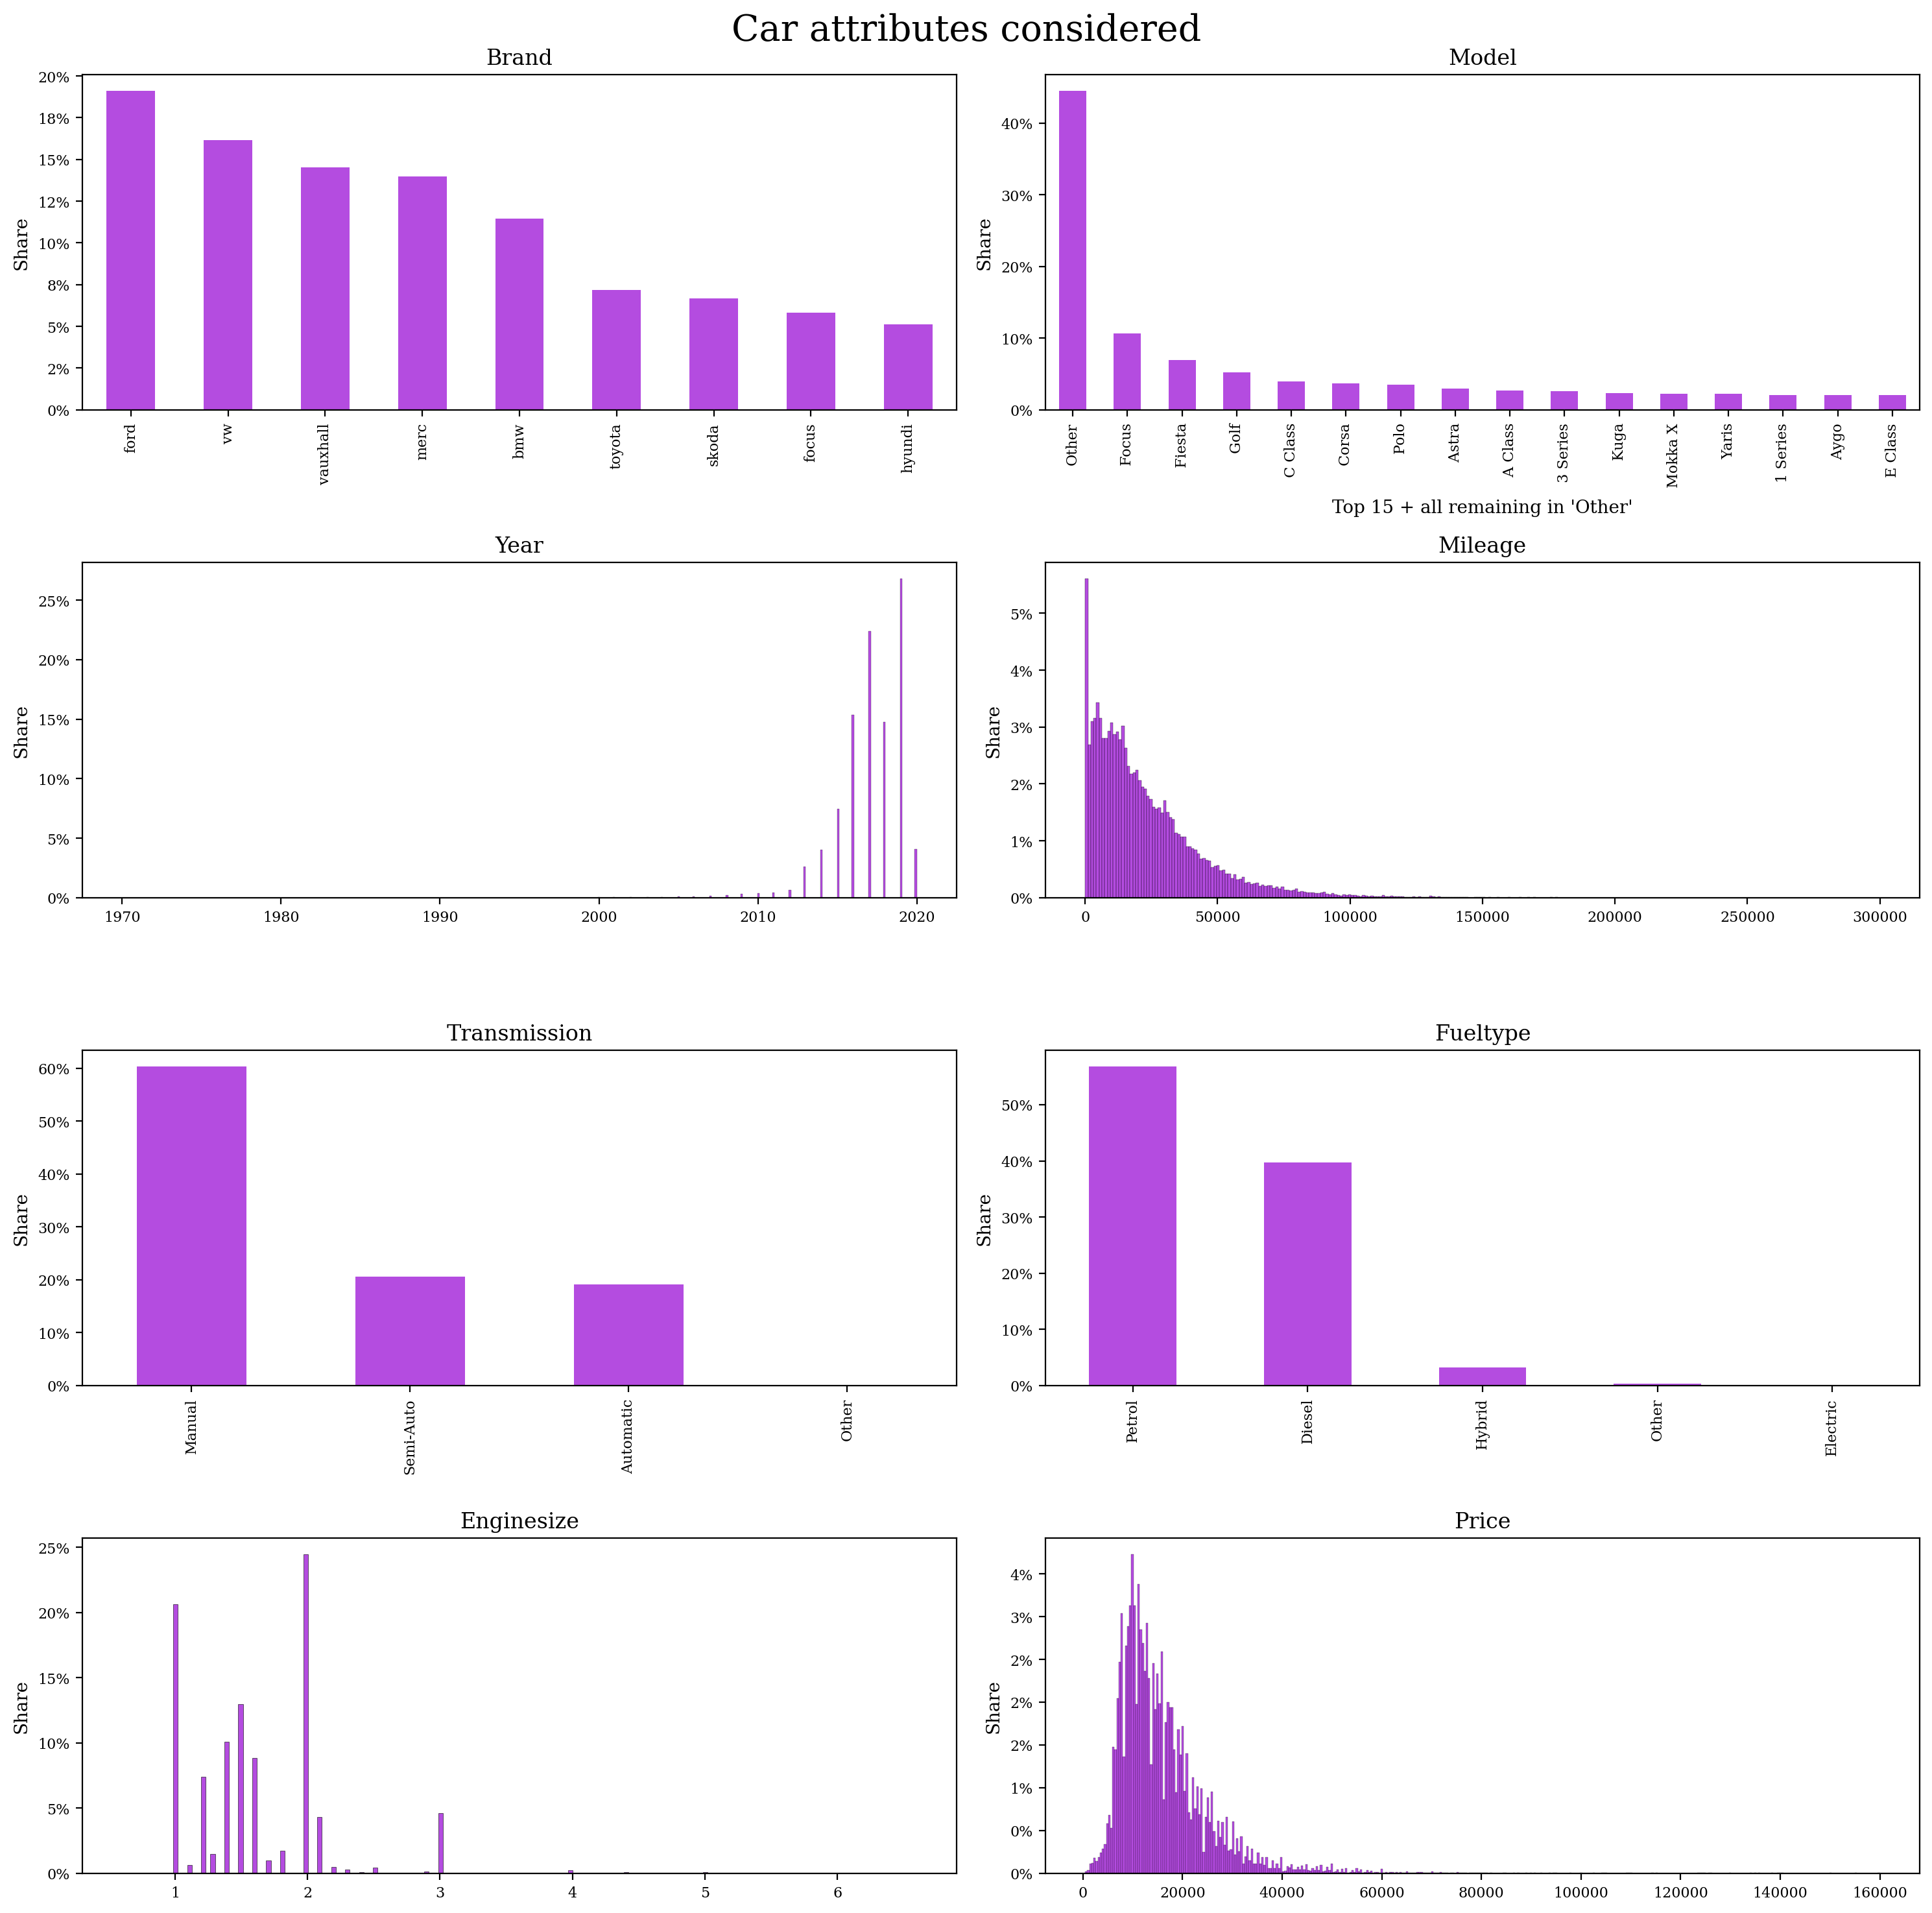

In [8]:
fig, axes = plt.subplots(4, (len(feature_cols) + 1) // 4, figsize=(15, 15))
plt.suptitle("Car attributes considered", fontsize=20)
axes = axes.flatten()
for i, c in enumerate(feature_cols + [target_col]):
    if c in categorical_feature_cols:
        if df[c].nunique() > 15:
            tmp = df[c].value_counts(normalize=True).reset_index()
            tmp.loc[15:, "index"] = "Other"
            tmp = tmp.groupby("index")[c].sum().sort_values(ascending=False)
            tmp.plot(kind="bar", ax=axes[i], color="darkviolet", alpha=.7)
            axes[i].set_xlabel("Top 15 + all remaining in 'Other'")
        else:
            df[c].value_counts(normalize=True).plot(kind="bar", ax=axes[i], color="darkviolet", alpha=.7)
    else:
        sns.histplot(data=df, x=c, ax=axes[i], stat="probability", color="darkviolet", alpha=.7)
        axes[i].set_xlabel("")
    axes[i].set_title(c.title())
    axes[i].set_ylabel("Share")
    axes[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x*100:,.0f}%"))
plt.tight_layout()

A few interesting insights stand out from these histograms:

- Only a tiny fraction of cars are EVs or hybrids.
- Most of the cars are sold at prices close to $£10,000$.
- Ford cars are the most popular ones, especially considering that the brand focus is most likely referring to the car model Ford Focus.

A more thorough analysis could surely be undertaken.<br/>
However, since data exploration and preparation are outside the scope of this blog post, we will skip them.

------
# Task

With a grasp of the data, let's imagine ourselves in the shoes of a car dealer, who has to decide, based on some relevant properties of a car, at what price to sell it for.

To support car dealers, we will provide them with an automated tool that suggests a somewhat optimal, initial price point based on the prices of historically sold cars.

Such a tool is assumed to simulate how car dealers naturally set prices, by looking at prices that similar cars fetched.

------
# Model

To solve the defined task, a Catboost Regressor is chosen. However, really any ensemble method of decision trees is supported.

For the purpose of modelling, somewhat default hyperparameters are used (only slightly modifying the number of estimators and size of leafs) and the data is randomly split in a 80-20 fashion.

In [9]:
# Initiate model
model = CatBoostRegressor(
    random_seed=46, 
    n_estimators=50,
    min_data_in_leaf=4
)

# Define name of prediction column
predicted_col = "predicted_" + target_col

In [10]:
df[categorical_feature_cols] = df[categorical_feature_cols].fillna("None").astype("category")

In [11]:
# Define splits
train_idx, test_idx = train_test_split(np.arange(len(df)), test_size=0.2)

df["set"] = None
df.loc[train_idx, "set"] = "train"
df.loc[test_idx, "set"] = "test"

df_train = df.loc[train_idx].copy()
df_test = df.loc[test_idx].copy()

In [12]:
# Train model
model.fit(
    df_train[feature_cols], 
    df_train[target_col], 
    cat_features=categorical_feature_cols, 
    verbose=False
);

In [13]:
# Make predictions
df[predicted_col] = model.predict(df[feature_cols]).astype(int)

In [14]:
# Evaluate model
df["absolute_percentage_error"] = (df[predicted_col] - df[target_col]).abs() / df[target_col]
df["relative_percentage_error"] = (df[predicted_col] - df[target_col]) / df[target_col]

(
    df
    .groupby("set")
    .agg(
        mean_relative_percentage_error=("relative_percentage_error", "mean"),
        mean_absolute_percentage_error=("absolute_percentage_error", "mean")
    )
    .T
    .style
    .format({
        "test": lambda x: "{:.1f}%".format(x*100),
        "train": lambda x: "{:.1f}%".format(x*100),
    })
)

set,test,train
mean_relative_percentage_error,1.3%,1.2%
mean_absolute_percentage_error,9.4%,9.4%


As one can see from the above results, the model performs decently well as it is off on average only by about 9% and tends to slightly over-predict the actual price (ca. 1% higher on average).

Again, the goal here is not to develop the best performing model, but rather to ensure that it accomplishes the task with reasonable accuracy and that no overfitting is present.

With the model trained, we can turn to the state-of-the-art XAI techniques in order to make this black box a bit more transparent.

------
# SHAP

In [15]:
model_explainer = shap.TreeExplainer(model)
shap_values = model_explainer(df_train[feature_cols])
shap_values_test = model_explainer(df_test[feature_cols])

Lime and SHAP are popular tools and in many aspects very similar. Hence, for the purpose of describing their common shortcoming that is the main focus point in this blog post, we will proceed using SHAP.

SHAP can be used to obtain global insights into what features are most important and how they affect the predictions of a model.<br/>
A concrete example would be obtaining the most important features in terms of their average, absolute contributions to the model predictions.<br/>
This is very often visualised using the built-in bar plot provided by SHAP.

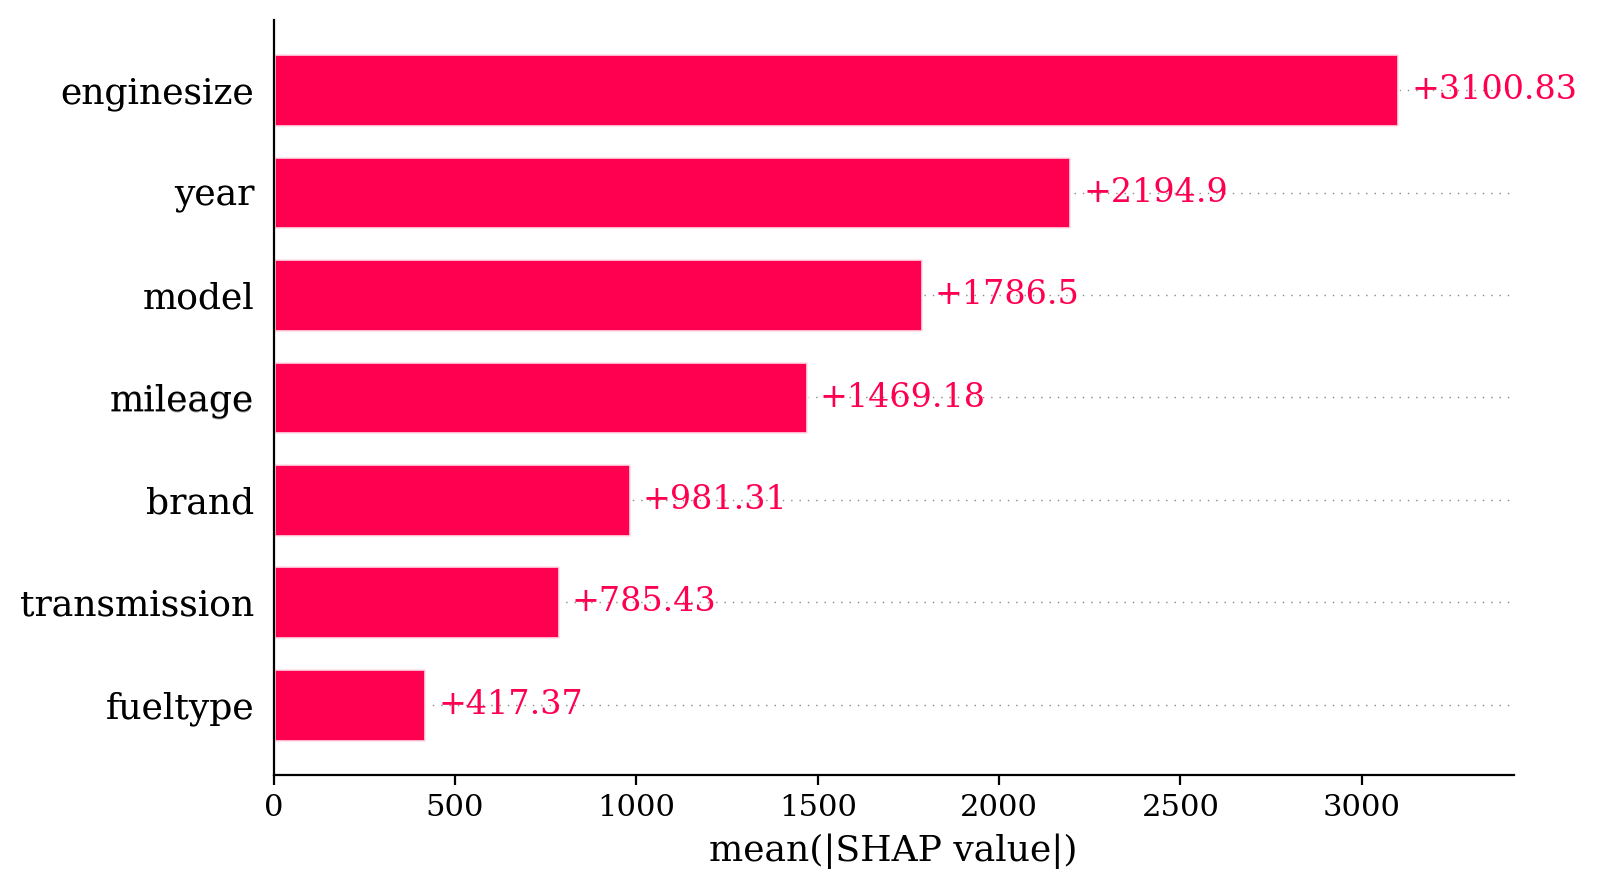

In [16]:
shap.plots.bar(shap_values)

Here, one can see that the engine size is by far the most relevant attribute of cars when it comes to predicting their sales prices (with an average absolute impact of $\approx £ 3,100$).

Similarly, the beeswarm plot is useful to gauge not only the impact but also the sign of the contribution. 

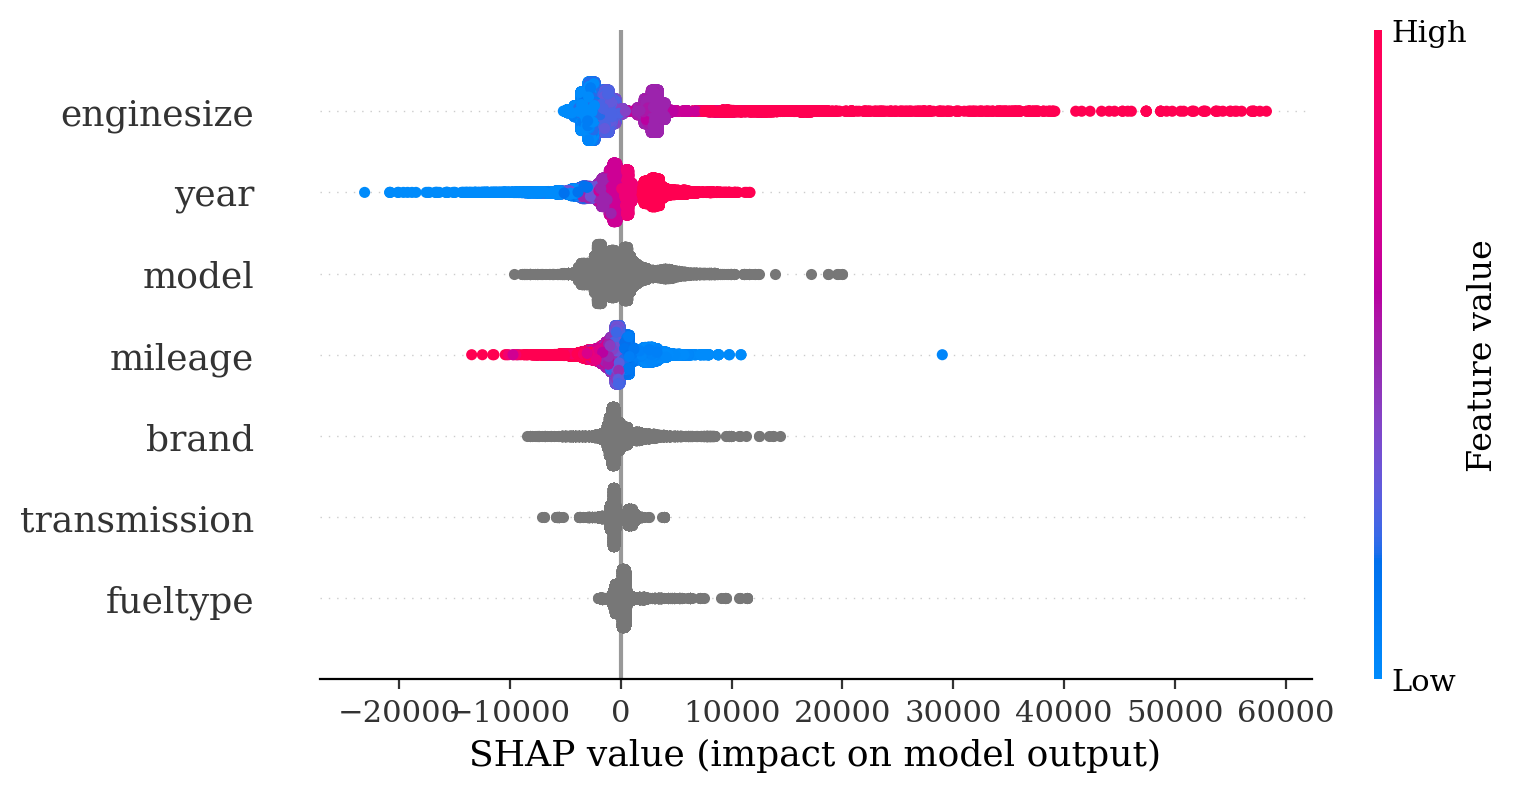

In [17]:
shap.plots.beeswarm(shap_values)

We can see that larger engine sizes (higher feature values, coloured in red) are related to higher predictions of sales prices (larger SHAP value).

SHAP can however also be used to obtain local explanations, i.e. explain the prediction of a particular instance, in our case a specific car we want to sell.

Consider the following car for which we would like to determine the sales price for:

In [18]:
df_test[feature_cols].iloc[0].to_frame().T

,brand,model,year,mileage,transmission,fueltype,enginesize
82928,merc,C Class,2019,3830,Semi-Auto,Petrol,3.0


To get some insight into what affected the decision of the model, we can use the popular waterfall plot:

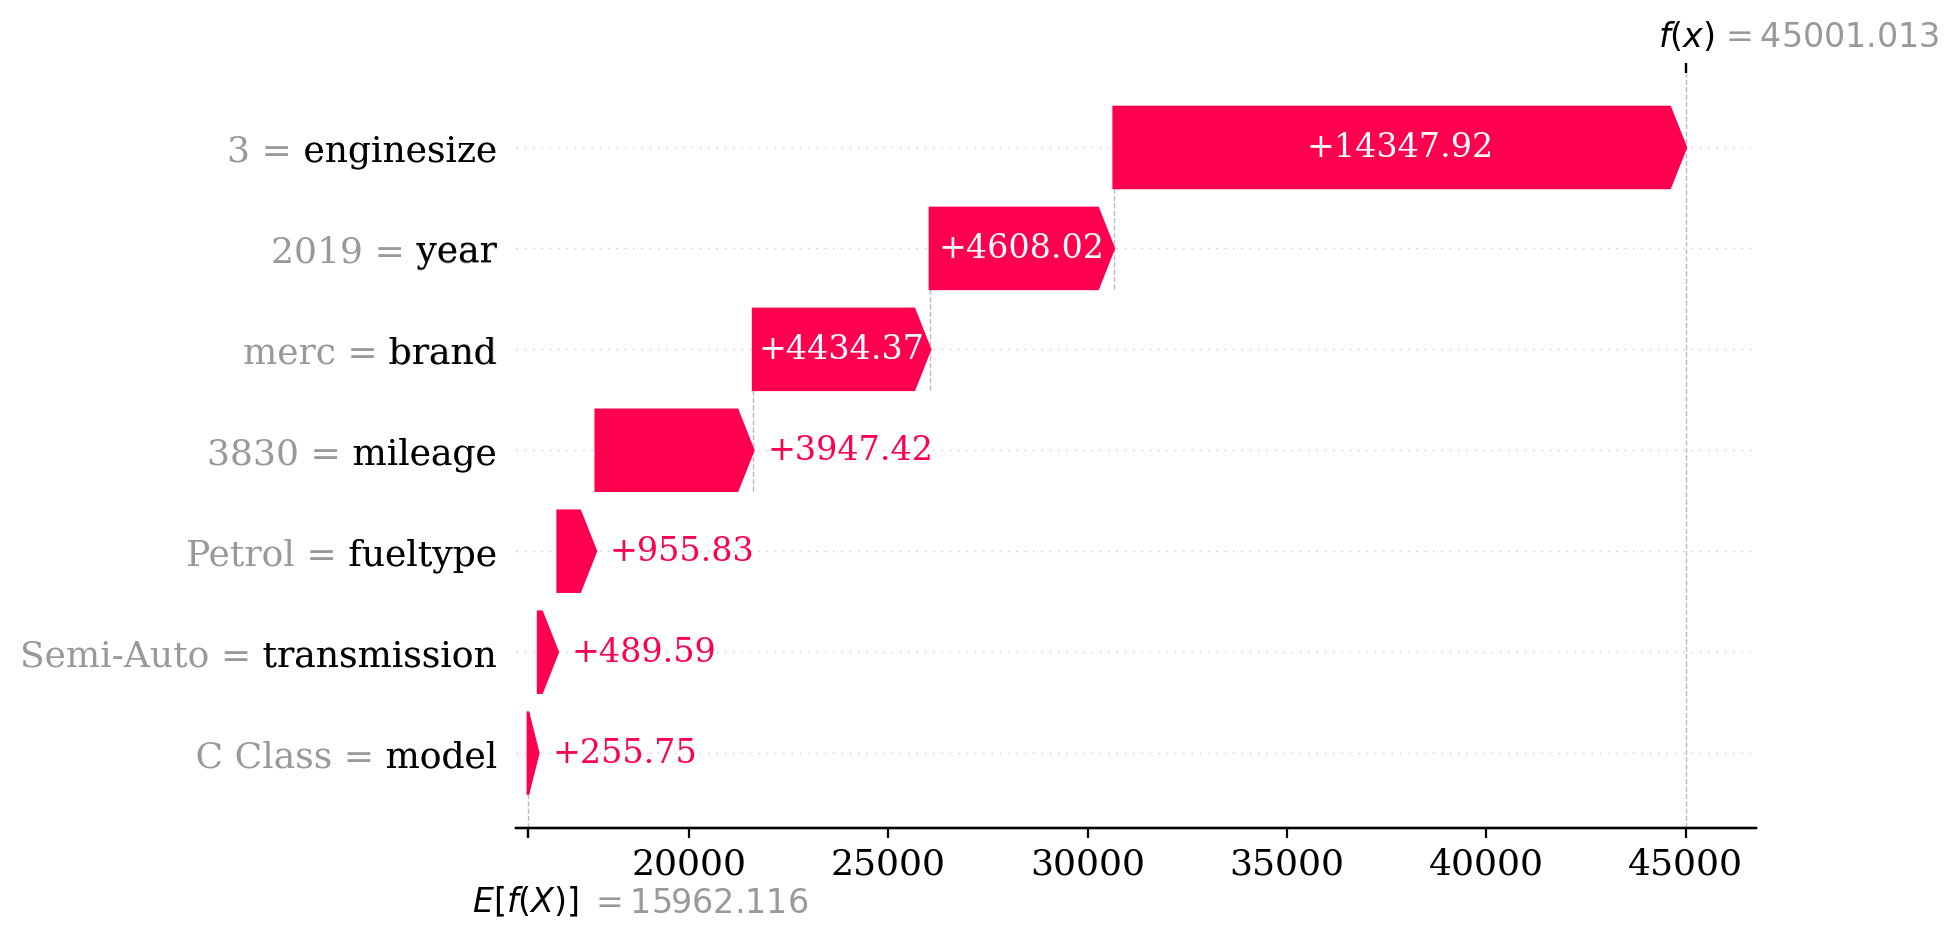

In [19]:
shap.plots.waterfall(shap_values_test[0])

The plot shows the influence of selected features on the model prediction $f(x)$ for this specific car compared to the average prediction of all the cars in the training set $E[f(X)]$. Concretely, the model expects the average car to sell for $E[f(X)] \approx £16,000$, while it predicts the selected car to sell for $f(x) \approx £45,000$.<br/>
A major reason why the model estimates the price of this car to be higher than that of the average one is its engine size of $3$ litre, which translates into an uplift from the mean expected sales price by $\approx £14,300$.

For car dealers however, the above explanations might not be very intuitive. They may not be interested in an explanation referencing the average car as it is not clear what the average car is without some insights into the dataset (see histograms in the Data section).<br/>
Rather, it might be more relevant to understand how this prediction compares to similar cars sold in the past.

To address this, we propose an approach to find similar training instances, i.e. those on which the model mostly bases its prediction on.<br/>
This way, car dealers can directly gauge the observed sales prices of similar cars and put those into perspective to understand where a predicted price is stemming from.

To this end, we introduce our example-based XAI technique named `LeafSim`.

----
# LeafSim

The proposed approach works only for decision trees and their ensemble derivatives, such as the popular Catboost algorithm.<br/>
It leverages how such models are built to easily extract similar training instances for a given prediction that one wishes to explain.

More specifically, each decision tree partitions the feature space by means of a series of binary questions.<br/>
Each question is a branch. If a branch is not followed by a subsequent question, the branch is colloquially known as a leaf.<br/>
Leaves are determined based on a chosen convergence criteria, such as RMSE for regression.<br/>
Further, leaves provide predictions based on the training observations ending up in them.<br/>
For regression, these predictions are based on, for example, the average of the target value of those observations.

This entire process is succinctly summarised in the following image taken from the [Encyclopedia of Machine Learning](https://link.springer.com/referenceworkentry/10.1007/978-0-387-30164-8_711), which visualises the case of regression using two predictor variables.

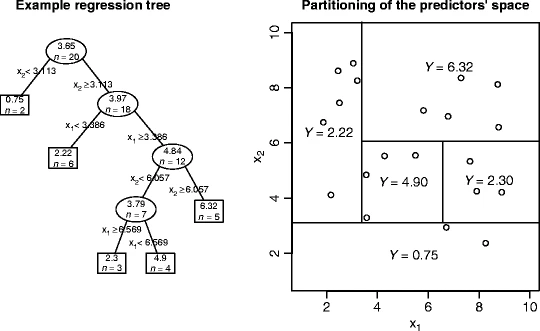

In [20]:
# Use Image to display so it can be rendered in PDF when running jupyter nbconvert --to webpdf --no-input notebook.ipynb
# As opposed to:
# <div>
# <img src="images/decision_tree_regression.jpg" width="600"/>
# </div>
Image(filename='../images/decision_tree_regression.jpg', width=600) 

Here, the squared boxes refer to the leaves and their associated prediction value is simply the average $Y$ value of the observations falling into them.

Based on this understanding of how decision trees are built and how they operate, it becomes evident that two data points ending up in the same leaf have very similar features (by virtue of satisfying the same conditions as imposed by binary questions that create branches) and similar targets (by virtue of satisfying the convergence criteria of leaves).

Thus, we define similar instances as the ones that end up most often in the same leaf across all decision trees in an ensemble. Hence the name `LeafSim`. This approach is loosely related to [[1]](https://arxiv.org/pdf/1802.06640.pdf), which introduced a method named LeafRefit to rank training instances based on the change in loss for a given test instance.

Visually, `LeafSim` can be represented as follows:

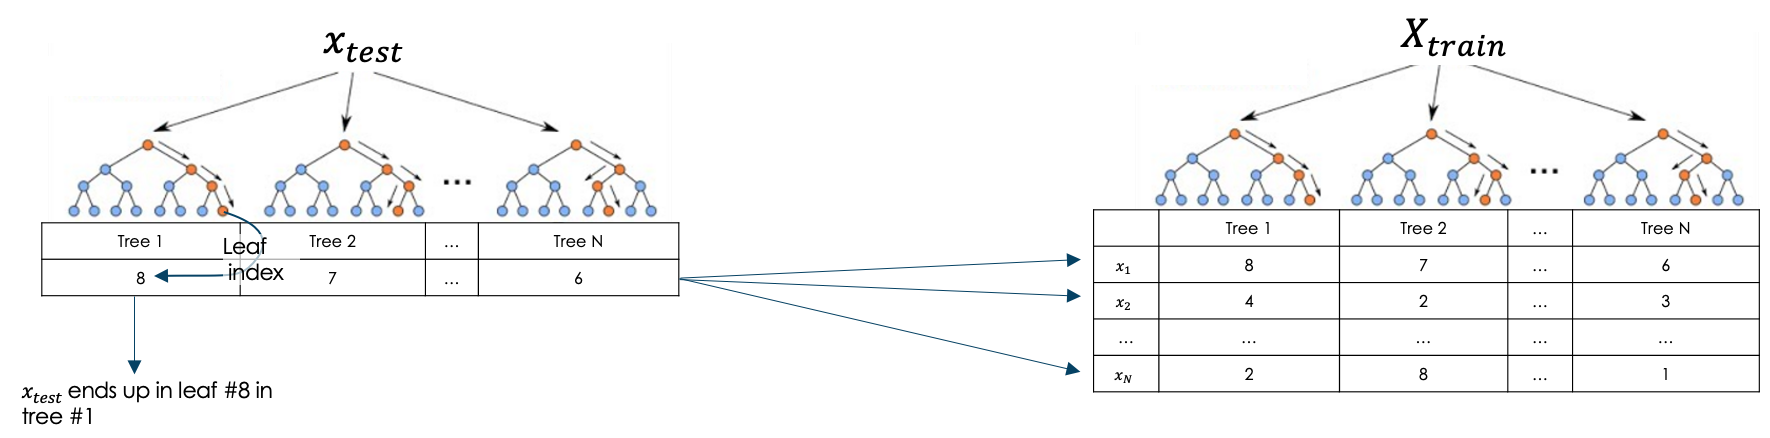

In [21]:
Image(filename='../images/leaf_index.png', width=1200) 

Here, $x_{test}$ is the instance for which we want to explain the prediction and $X_{train}$ are all the instances in the training data, with $x_i$ being an individual observation (in our case a car).

Similarity can thus be measured using the [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance).<br/>
Briefly, the Hamming distance captures, for two strings of equal length, the number of positions for which the symbols differ. <br/>
This allows us to measure the number of times leaf indices are different across the trees.<br/>
By dividing this number by the number of trees and subtracting it from $1$, one can transform it into a bounded similarity metric.

-------
# Implementation

In the case of Catboost, `LeafSim` can easily leverage the built-in function [`calc_leaf_indexes`](https://catboost.ai/en/docs/concepts/python-reference_catboost_calc_leaf_indexes) to obtain the leaf indices.
For `XGBoost` the equivalent would be [`apply`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor.apply).


In [22]:
# Get a matrix with each row containing the leaf indices across all trees for a given instance
leaves_idx_training = model.calc_leaf_indexes(
    df_train[feature_cols],
    ntree_start=0,
    ntree_end=0,
    thread_count=-1,
    verbose=False
)
leaves_idx_test = model.calc_leaf_indexes(
    df_test[feature_cols],
    ntree_start=0,
    ntree_end=0,
    thread_count=-1,
    verbose=False
)

In [23]:
%%time
# Calculate similarity using the Hamming distance (can take a minute or so)
distances = (
    DistanceMetric
    .get_metric("hamming")
    .pairwise(X=leaves_idx_test, Y=leaves_idx_training)
)

CPU times: user 49.9 s, sys: 4.63 s, total: 54.5 s
Wall time: 54.2 s


In [24]:
# The shape of this distance matrix is (# instaces to explain, # training instances)
distances.shape

(18749, 74995)

In [25]:
%%time
# NOTE: argsort can take a few minutes (between 2 or 3min)
sorted_distances = np.argsort(distances, axis=1)

CPU times: user 1min 9s, sys: 28.3 s, total: 1min 37s
Wall time: 2min 23s


In [26]:
# For each instance we want to explain, select only the top N similar training instances
N = 10
top_sorted_distances = sorted_distances[:, :N]

In [27]:
%%time
# For the top N most similar training instances, 
# obtain their corresponding similarity score and ID
top_n_distances = np.stack([distances[i, top_sorted_distances[i, :]] for i in range(distances.shape[0])])
top_n_distances_id = np.stack([df_train.ID.values[top_sorted_distances[i, :]] for i in range(distances.shape[0])])

CPU times: user 820 ms, sys: 5.95 s, total: 6.77 s
Wall time: 39.4 s


----
# Examples

To understand how these `LeafSim` scores can be leveraged, let's proceed with analysing two concrete examples.

In [28]:
# Get the most important features according to SHAP as a list
# These features will be used when showing similar instances
abs_mean_shap_values = np.abs(shap_values.values).mean(0)  # Measure importance in absolute terms
df_feature_importance = pd.DataFrame(
    list(zip(feature_cols, abs_mean_shap_values)),
    columns=['feature_name', 'feature_importance']
).sort_values(by=['feature_importance'], ascending=False)
top_n_features = list(df_feature_importance.feature_name.values[:8])  # Restrict ourselves to the top 8 most influential features

# Define the formatting of some columns
formatting = {
    target_col: lambda x: f"£ {x:,.0f}", 
    predicted_col: lambda x: f"£ {x:,.0f}", 
    "similarity": lambda x: f"{x*100:.0f}%",
    "enginesize": lambda x: f"{x:.1f}"
}

In [29]:
%%time
sliced_distances = sorted_distances[:, :50]
avg_top_sim = (1 - np.stack([distances[i, sliced_distances[i, :]] for i in range(distances.shape[0])])).mean(axis=1)
df_test["avg_top_sim"] = avg_top_sim

CPU times: user 861 ms, sys: 7.8 s, total: 8.67 s
Wall time: 30.8 s


In [30]:
# Wrap the utils function into another function to reduce the number of parameters we have to pass
_get_stylised_similar_cars_table = lambda a_idx, a_id: get_stylised_similar_cars_table(
    df,
    top_n_distances_id,
    top_n_distances,
    a_idx,
    a_id,
    top_n_features,
    target_col,
    formatting
)

_get_similarity_plots = lambda a_idx, a_id: get_similarity_plots(
    df,  
    df_train,
    distances, 
    a_idx, 
    a_id, 
    avg_top_sim
)

## Example 1

As a first example, let's pick a rather frequently occuring vehicle, such as a Hyundai, as one expects the model to predict these cars rather well.

In [31]:
# Pick an electric car
car_to_explain_idx = 73  # index in df_test
car_to_explain_id = df_test.iloc[car_to_explain_idx].ID  # ID, i.e. index in df

In [32]:
display(
    df
    .loc[
        car_to_explain_id, 
        top_n_features + [predicted_col, target_col]
    ]
    .to_frame()
    .T
    .style
    .format(formatting)
)

,enginesize,year,model,mileage,brand,transmission,fueltype,predicted_price,price
42645,1.0,2020,I30,4000,hyundi,Manual,Petrol,"£ 15,570","£ 15,795"


The table above describes the attributes of our selected car alongside the model prediction and the car's actual sales price. 

We can see the model provides a very good prediction, but we would like to understand which cars in the training set this prediction is mostly based on.

For simplicity, we restrict ourselves to the Top 10 cars with the highest `LeafSim` score, i.e. the 10 cars that most often end up in the same leaf as the car we want to explain.

These Top 10 cars are described in the table below.

In [33]:
display(_get_stylised_similar_cars_table(car_to_explain_id, car_to_explain_idx))

,enginesize,year,model,mileage,brand,transmission,fueltype,similarity,price
0,1.0,2020,I30,3363,hyundi,Manual,Petrol,96%,"£ 15,495"
1,1.0,2019,I30,4000,hyundi,Manual,Petrol,92%,"£ 13,990"
2,1.4,2020,I30,4000,hyundi,Manual,Petrol,90%,"£ 16,995"
3,1.0,2020,I30,2936,hyundi,Manual,Petrol,90%,"£ 15,495"
4,1.0,2019,I30,6175,hyundi,Manual,Petrol,88%,"£ 13,990"
5,1.0,2019,I30,5449,hyundi,Manual,Petrol,88%,"£ 13,498"
6,1.0,2019,I30,3154,hyundi,Manual,Petrol,86%,"£ 15,495"
7,1.0,2020,I30,37,hyundi,Manual,Petrol,86%,"£ 19,995"
8,1.0,2020,I30,100,hyundi,Manual,Petrol,86%,"£ 15,985"
9,1.0,2019,I30,6416,hyundi,Manual,Petrol,84%,"£ 14,030"


The colours in the table represent the closeness to the car we want to explain.<br/>
The lighter the shade of red of a cell, the more similar the two cars are in this respect.<br/>
For the similarity column, the darker the shade, the more similar the two cars.

We can see that for the most important features, the provided cars are indeed very similar, close to the same actually.<br/>
Their sales prices are also very much in line with the selected car's predicted sales price.

In the above table, we have restricted ourselves to the Top 10.<br/>
But we could also investigate the relationship between price and the `LeafSim` score across the entire training set.

This is shown in the following plot on the left.

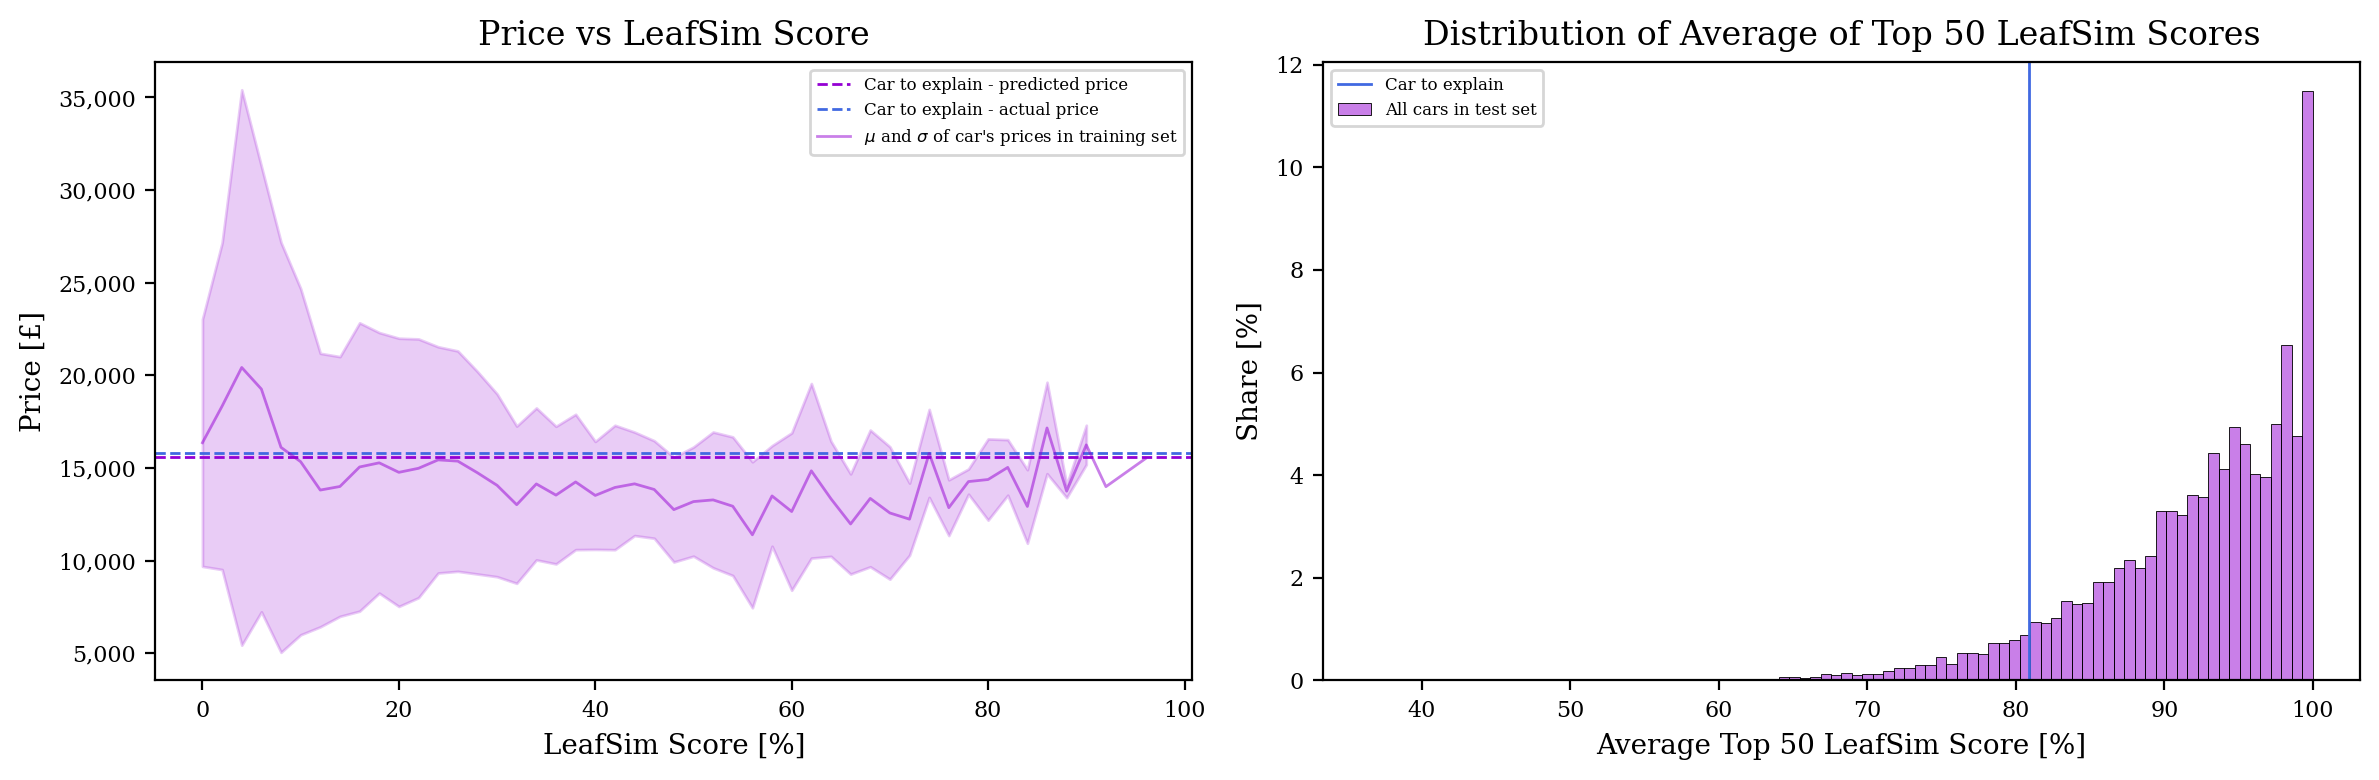

In [34]:
_get_similarity_plots(car_to_explain_idx, car_to_explain_id)

The prices of cars with a higher `LeafSim` score vary less and are generally closer to the prediction of the car we want to explain.

In order to put the `LeafSim` score of this particular car in perspective, the plot on the right shows the distribution of the average `LeafSim` score for the Top 50 training instances. One can see that this car has quite a few decently similar training instances (the mean `LeafSim` score of the Top 50 is roughly 82%).<br/>
This means the model is basing it's prediction on very relevant training samples and therefore the prediction can be assumed to be fairly accurate.

## Example 2

As a second example, let's pick an electric car, because these are drastically under-represented in the dataset and hence the model performs poorly on them.

In [35]:
# Test set error rate by fueltype
(
    df
    .query("set == 'test'")
    .groupby(["fueltype"])
    .agg(
        mean_absolute_percentage_error=("absolute_percentage_error", "mean")
    )
    .sort_values(by="mean_absolute_percentage_error")
    .style
    .format({
        "mean_absolute_percentage_error": lambda x: "{:.1f}%".format(x*100),
    })
)

,mean_absolute_percentage_error
fueltype,
Hybrid,7.8%
Petrol,9.1%
Diesel,10.1%
Other,10.4%
Electric,31.7%


Indeed, the error rate of EVs is roughly 3x larger than for any other fuel type.

In [36]:
# Pick an electric car
car_to_explain_idx = 9601  # index in df_test
car_to_explain_id = df_test.iloc[car_to_explain_idx].ID  # ID, i.e. index in df

Specifically, let's pick this electric car:

In [37]:
display(
    df
    .loc[car_to_explain_id]
   [top_n_features + [predicted_col, target_col]]
    .to_frame()
    .T
    .style
    .format(formatting)
)

,enginesize,year,model,mileage,brand,transmission,fueltype,predicted_price,price
13284,1.4,2015,Ampera,34461,vauxhall,Automatic,Electric,"£ 17,123","£ 12,999"


We already see that the predicted price is quite different from the actual price.

In a real world setting however, we do not know the actual price.<br/>
This is because the tool will be used by car dealers to set the selling price and thus the car has not been sold yet.<br/>
Hence, to better understand what this prediction is based on and whether one can fully trust it, we can again turn to the most similar training examples as identified by `LeafSim`.

In [38]:
display(_get_stylised_similar_cars_table(car_to_explain_id, car_to_explain_idx))

,enginesize,year,model,mileage,brand,transmission,fueltype,similarity,price
0,1.0,2015,i3,29465,bmw,Automatic,Electric,46%,"£ 17,400"
1,1.8,2015,Prius,32314,toyota,Automatic,Hybrid,44%,"£ 15,499"
2,1.8,2015,Prius,28001,toyota,Automatic,Other,42%,"£ 21,795"
3,1.8,2015,Prius,30862,toyota,Automatic,Other,42%,"£ 21,990"
4,1.8,2015,Prius,25360,toyota,Automatic,Hybrid,40%,"£ 23,995"
5,1.5,2015,i8,43323,bmw,Automatic,Hybrid,40%,"£ 44,990"
6,1.5,2015,i8,43102,bmw,Automatic,Hybrid,40%,"£ 42,890"
7,1.8,2015,Prius,48911,toyota,Automatic,Hybrid,40%,"£ 18,795"
8,1.8,2015,Prius,42929,toyota,Automatic,Other,40%,"£ 12,000"
9,1.8,2015,Prius,19350,toyota,Automatic,Hybrid,38%,"£ 17,495"


In this particular case, we can clearly see that the most similar training instances are not very close to the predicted car.

The `LeafSim` scores are low (below 50%) and crucial attributes, such as brand, model and fuel type vary considerably.

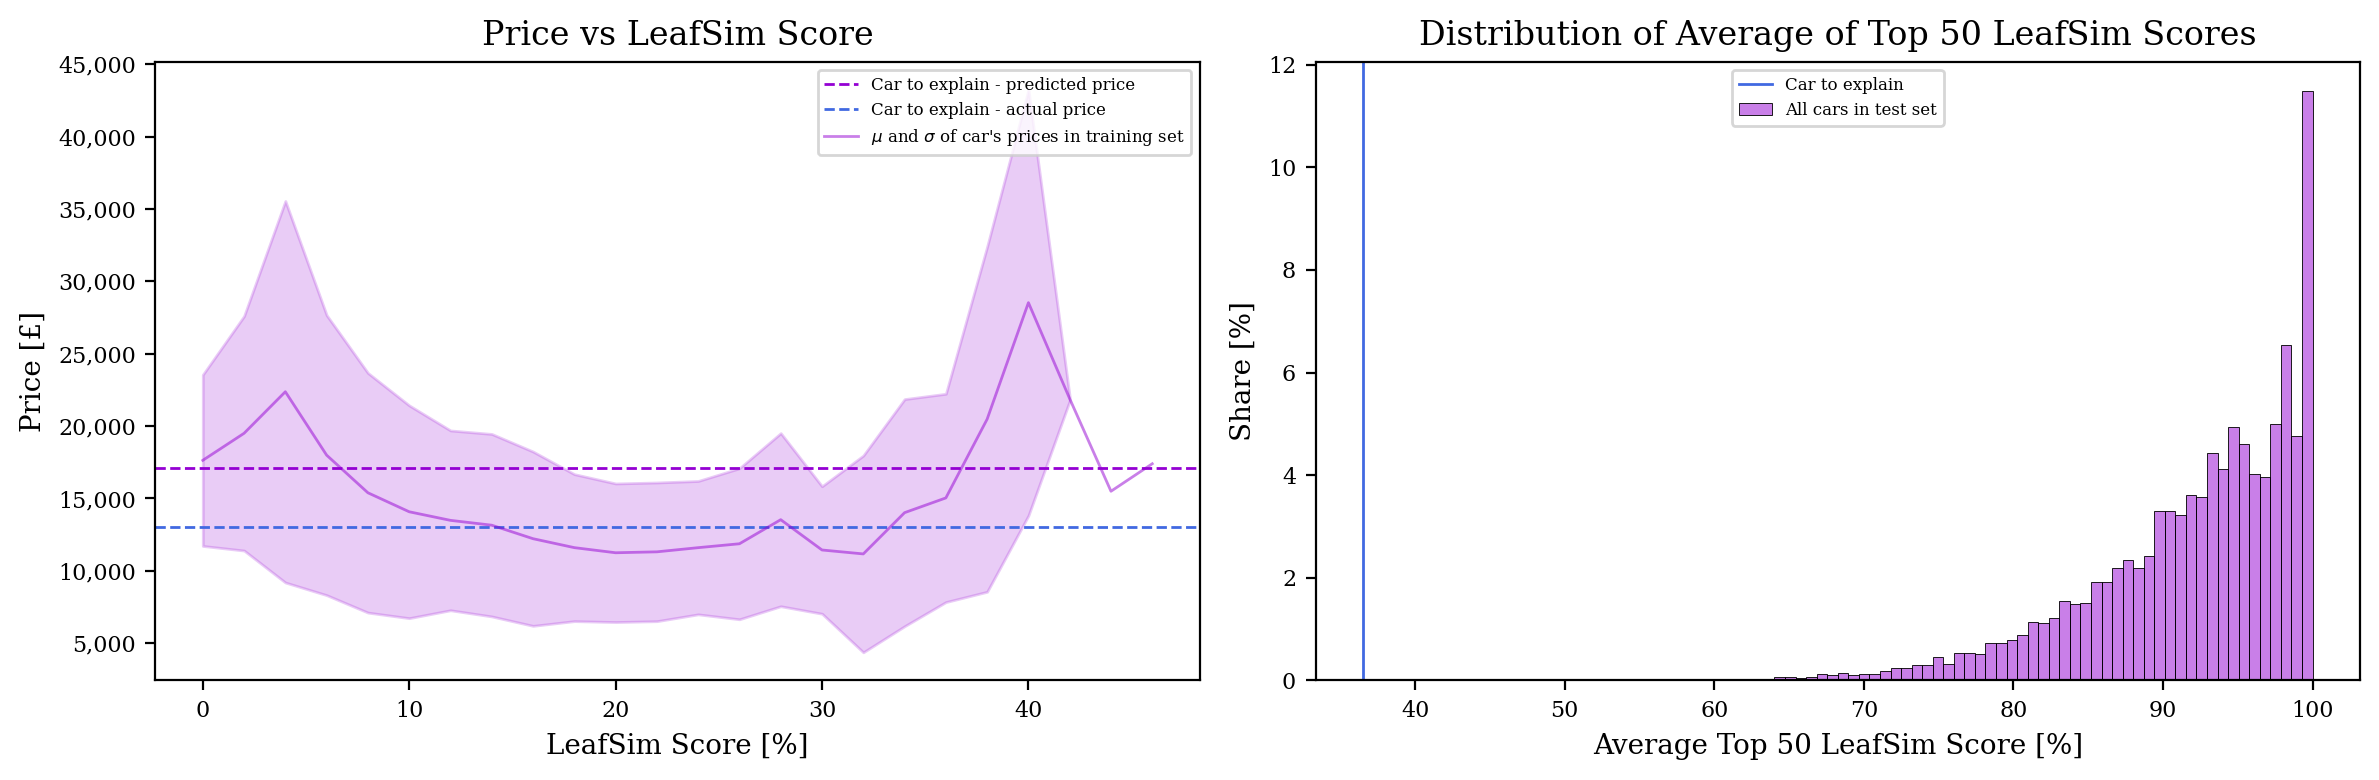

In [39]:
_get_similarity_plots(car_to_explain_idx, car_to_explain_id)

We also see from the above plot on the left, that prices still vary a lot even for the most similar cars.<br/>
From the plot on the right we can clearly see that the average `LeafSim` scores of the most related training instances is indeed very low.

Therefore, car dealers should lower their confidence in the model prediction for this particular car.

----
# Conclusion

This blog post addressed the interpretability gap of popular XAI techniques, such as SHAP and Lime, when it comes to their use by people with limited knowledge in Machine Learning.

Specifically, an example-based explainability approach for decision-tree based ensemble methods was proposed, which identifies the most relevant instances in the training set on which the model bases a particular prediction on.

This measure of relevancy is expressed using the `LeafSim` score, which captures how often observations end up in the same leaf.

Mainly by means of a qualitative assessment of selected examples, we showed that the `LeafSim` score indeed reflects similarity between observations. Observations with higher `LeafSim` scores tend to be more accurately predicted by the model and therefore such scores can be used by an end-user to adjust their confidence in model predictions.

------
# References

[1] Sharchilev, Boris, Yury Ustinovskiy, Pavel Serdyukov, and Maarten Rijke. "Finding influential training samples for gradient boosted decision trees." In International Conference on Machine Learning, pp. 4577-4585. PMLR, 2018.

----
# Appendix

## Technical Considerations

- Each tree has the same weight in `LeafSim`, which, depending on the Machine Learning method we would like to explain, may not be the most faithful approach.
    - For example in the case of Catboost, trees have different weights based on how accurate they are. In this setting, a weighted distance metric rather than the Hamming distance would be better suited. However, as the results in this blog post suggest, using a non-weighted metric still provides good approximations.

In [ ]:
# Pick an electric car
car_to_explain_id = 66744 # 42873
car_to_explain_idx = df_test.index.tolist().index(car_to_explain_id)

display(
    df
    .loc[car_to_explain_id]
   [top_n_features + [predicted_col, target_col]]
    .to_frame()
    .T
    .style
    .format(formatting)
)

display(_get_stylised_similar_cars_table(car_to_explain_id, car_to_explain_idx))

_get_similarity_plots(car_to_explain_idx, car_to_explain_id)